# **Part1: Model Creation for CNN Classification**


## 1- Importing Important Libraries 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPool2D, Flatten,GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNet
import cv2
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2- Defining our Dataset

In [2]:
# Define the path to the 'cats' and 'dogs' directories
DIRECTORY = 'newdata/train'
cats_dir = os.path.join(DIRECTORY, 'cats')
dogs_dir = os.path.join(DIRECTORY, 'dogs')

# List all files in the 'cats' and 'dogs' directories
cat_images = [os.path.join(DIRECTORY, file) for file in os.listdir(cats_dir)]
dog_images = [os.path.join(DIRECTORY, file) for file in os.listdir(dogs_dir)]

print(f"Number of cat images: {len(cat_images)}")
print(f"Number of dog images: {len(dog_images)}")

Number of cat images: 11500
Number of dog images: 11500


### Variables

In [3]:
IMG_SIZE=128
BATCH_SIZE=32

## 3- Data Augmentation

In [4]:
# Initialize ImageDataGenerator with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,          # Reduced rotation to 15 degrees
    width_shift_range=0.1,      # Moderate width shift
    height_shift_range=0.1,     # Moderate height shift
    shear_range=0.1,            # Moderate shear
    zoom_range=0.1,             # Moderate zoom
    horizontal_flip=True,       # Horizontal flip
    fill_mode='nearest',
    validation_split=0.1        # Use 10% of data for validation
)

# Set up the training generator
train_generator = train_datagen.flow_from_directory(
    DIRECTORY,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.1)
# Set up the validation generator
val_generator = val_datagen.flow_from_directory(
    DIRECTORY,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20700 images belonging to 2 classes.
Found 2300 images belonging to 2 classes.


## 4- Balanced Dataset Verification

In [5]:
print("Class indices:", train_generator.class_indices)


Class indices: {'cats': 0, 'dogs': 1}


Class distribution in train_generator:
cats: 10395
dogs: 10305


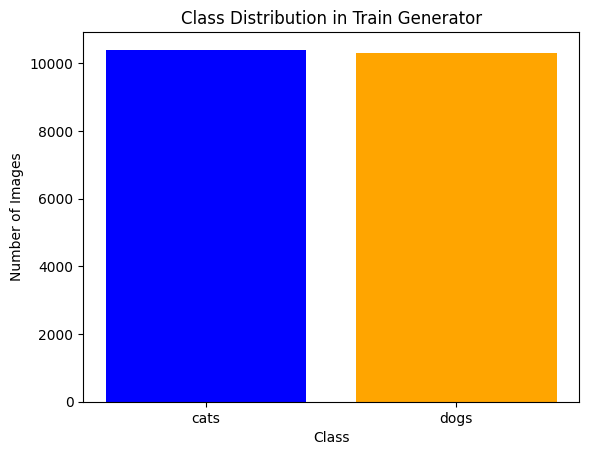

In [7]:
# Get the number of images in each class from the train_generator
class_counts = {label: 0 for label in train_generator.class_indices.keys()}

# Loop through the generator and count labels
for _ in range(len(train_generator)):
    _, labels = next(train_generator)
    unique, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique, counts):
        class_name = "cats" if label == 0 else "dogs"
        class_counts[class_name] += count

# Print the class counts
print("Class distribution in train_generator:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot the class distribution with specific colors
colors = ['blue' if class_name == 'cats' else 'orange' for class_name in class_counts.keys()]
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.title("Class Distribution in Train Generator")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


## 5- Displaying Images before and after editing

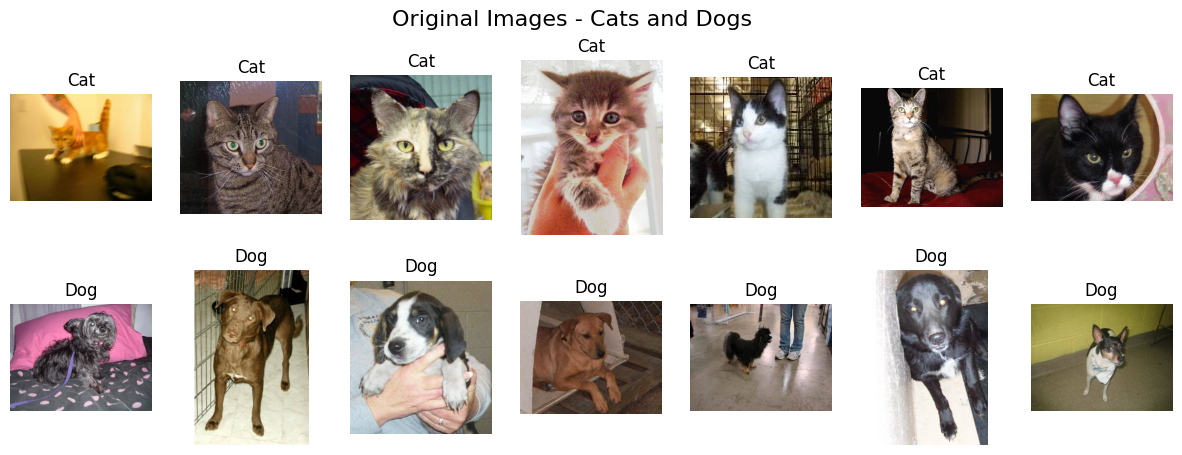

In [8]:
num_images = 7  # Number of images to display per category

# Function to load and display original images from each category in one plot
def display_original_images(cat_dir, dog_dir, num_images):
    plt.figure(figsize=(15, 5))
    plt.suptitle("Original Images - Cats and Dogs", fontsize=16)

    # Load cat images
    cat_images = os.listdir(cat_dir)[:num_images]
    for i, img_name in enumerate(cat_images):
        img_path = os.path.join(cat_dir, img_name)
        img = plt.imread(img_path)  # Load image without any transformation
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.title("Cat")
        plt.axis('off')

    # Load dog images
    dog_images = os.listdir(dog_dir)[:num_images]
    for i, img_name in enumerate(dog_images):
        img_path = os.path.join(dog_dir, img_name)
        img = plt.imread(img_path)  # Load image without any transformation
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(img)
        plt.title("Dog")
        plt.axis('off')

    plt.show()

# Display original images
display_original_images(cats_dir, dogs_dir, num_images)

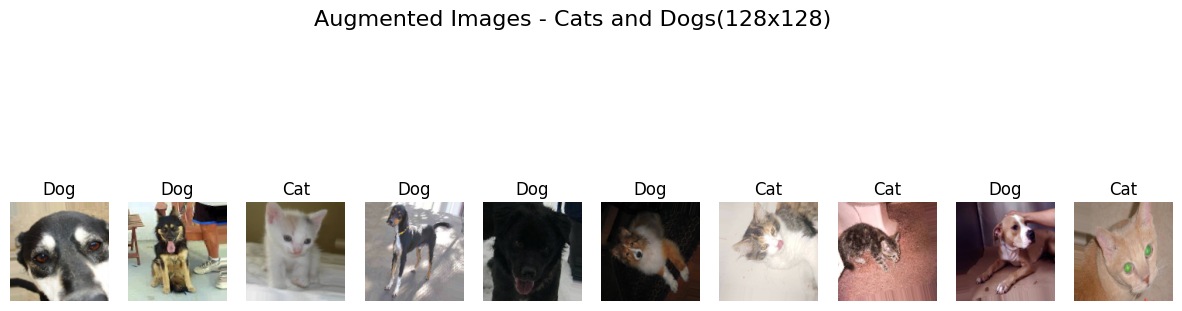

In [9]:
def display_augmented_images(generator, num_images):
    plt.figure(figsize=(15, 5))
    plt.suptitle("Augmented Images - Cats and Dogs(128x128)", fontsize=16)

    # Get a batch of images and labels
    img_batch, label_batch = next(generator)

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_batch[i])  # Display the augmented image
        # Use binary label directly (0 = Cat, 1 = Dog)
        plt.title("Cat" if label_batch[i] == 0 else "Dog")
        plt.axis('off')

    plt.show()

# Display a few augmented images
display_augmented_images(train_generator,10)


## 6- Displaying the Shape of Data

In [10]:
# Get a batch from the training generator
train_batch, train_labels = next(train_generator)
print("Training batch shape:", train_batch.shape)      # Expected: (batch_size, IMG_SIZE, IMG_SIZE, 3)
print("Training labels shape:", train_labels.shape)    # Expected: (batch_size, num_classes)

# Get a batch from the validation generator
val_batch, val_labels = next(val_generator)
print("Validation batch shape:", val_batch.shape)      # Expected: (batch_size, IMG_SIZE, IMG_SIZE, 3)
print("Validation labels shape:", val_labels.shape)    # Expected: (batch_size, num_classes)


Training batch shape: (32, 128, 128, 3)
Training labels shape: (32,)
Validation batch shape: (32, 128, 128, 3)
Validation labels shape: (32,)


In [11]:
images, labels = next(train_generator)

# Print the shapes to confirm the structure
print("Batch of images shape:", images.shape)  # Expected shape: (batch_size, IMG_SIZE, IMG_SIZE, 3)
print("Batch of labels shape:", labels.shape)  # Expected shape: (batch_size, num_classes)

# Inspect pixel values of the first image in the batch
print("Pixel values of the first image in the batch:")
print(images[0])  # This will print a (IMG_SIZE, IMG_SIZE, 3) array of pixel values

# Inspect label of the first image in the batch
print("Label of the first image in the batch:")
print(labels[0]) 

Batch of images shape: (32, 128, 128, 3)
Batch of labels shape: (32,)
Pixel values of the first image in the batch:
[[[0.9333334  0.9333334  0.9333334 ]
  [0.9333334  0.9333334  0.9333334 ]
  [0.93505406 0.93505406 0.93505406]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.9333334  0.9333334  0.9333334 ]
  [0.9333334  0.9333334  0.9333334 ]
  [0.93449503 0.93449503 0.93449503]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.9333334  0.9333334  0.9333334 ]
  [0.9333334  0.9333334  0.9333334 ]
  [0.933936   0.933936   0.933936  ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[0.8980318  0.8941102  0.92548275]
  [0.90307534 0.89915377 0.9305263 ]
  [0.9081189  0.90419734 0.9355699 ]
  ...
  [0.68598974 0.6938329  0.68206817]
  [0.53128755 0.5342676  0.5346605

## 7- Model Creation

In [12]:
model = Sequential()

# First convolutional block
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional block
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Third convolutional block
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Fourth convolutional block (increase complexity)
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [27]:
# from tensorflow.keras.utils import plot_model

# # Plot the model architecture
# plot_model(model, show_shapes=True, show_layer_names=True)


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# # Train the model with generators
# tf.autograph.set_verbosity(0)

# hist = model.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator
# )

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


647/647 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.5989WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001A740ECD620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
647/647 [==============================] - 751s 1s/step - loss: 0.6556 - accuracy: 0.5989 - val_loss: 0.5920 - val_accuracy: 0.6974
Epoch 2/20
6

In [15]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime

#  Set up TensorBoard log directory and callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# # Train the model with TensorBoard and EarlyStopping

hist = model.fit(
     train_generator,
     epochs=20,
     validation_data=val_generator,
     callbacks=[tensorboard_callback]
)


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


647/647 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.5894WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C87DA0E8E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach t

## BONUS

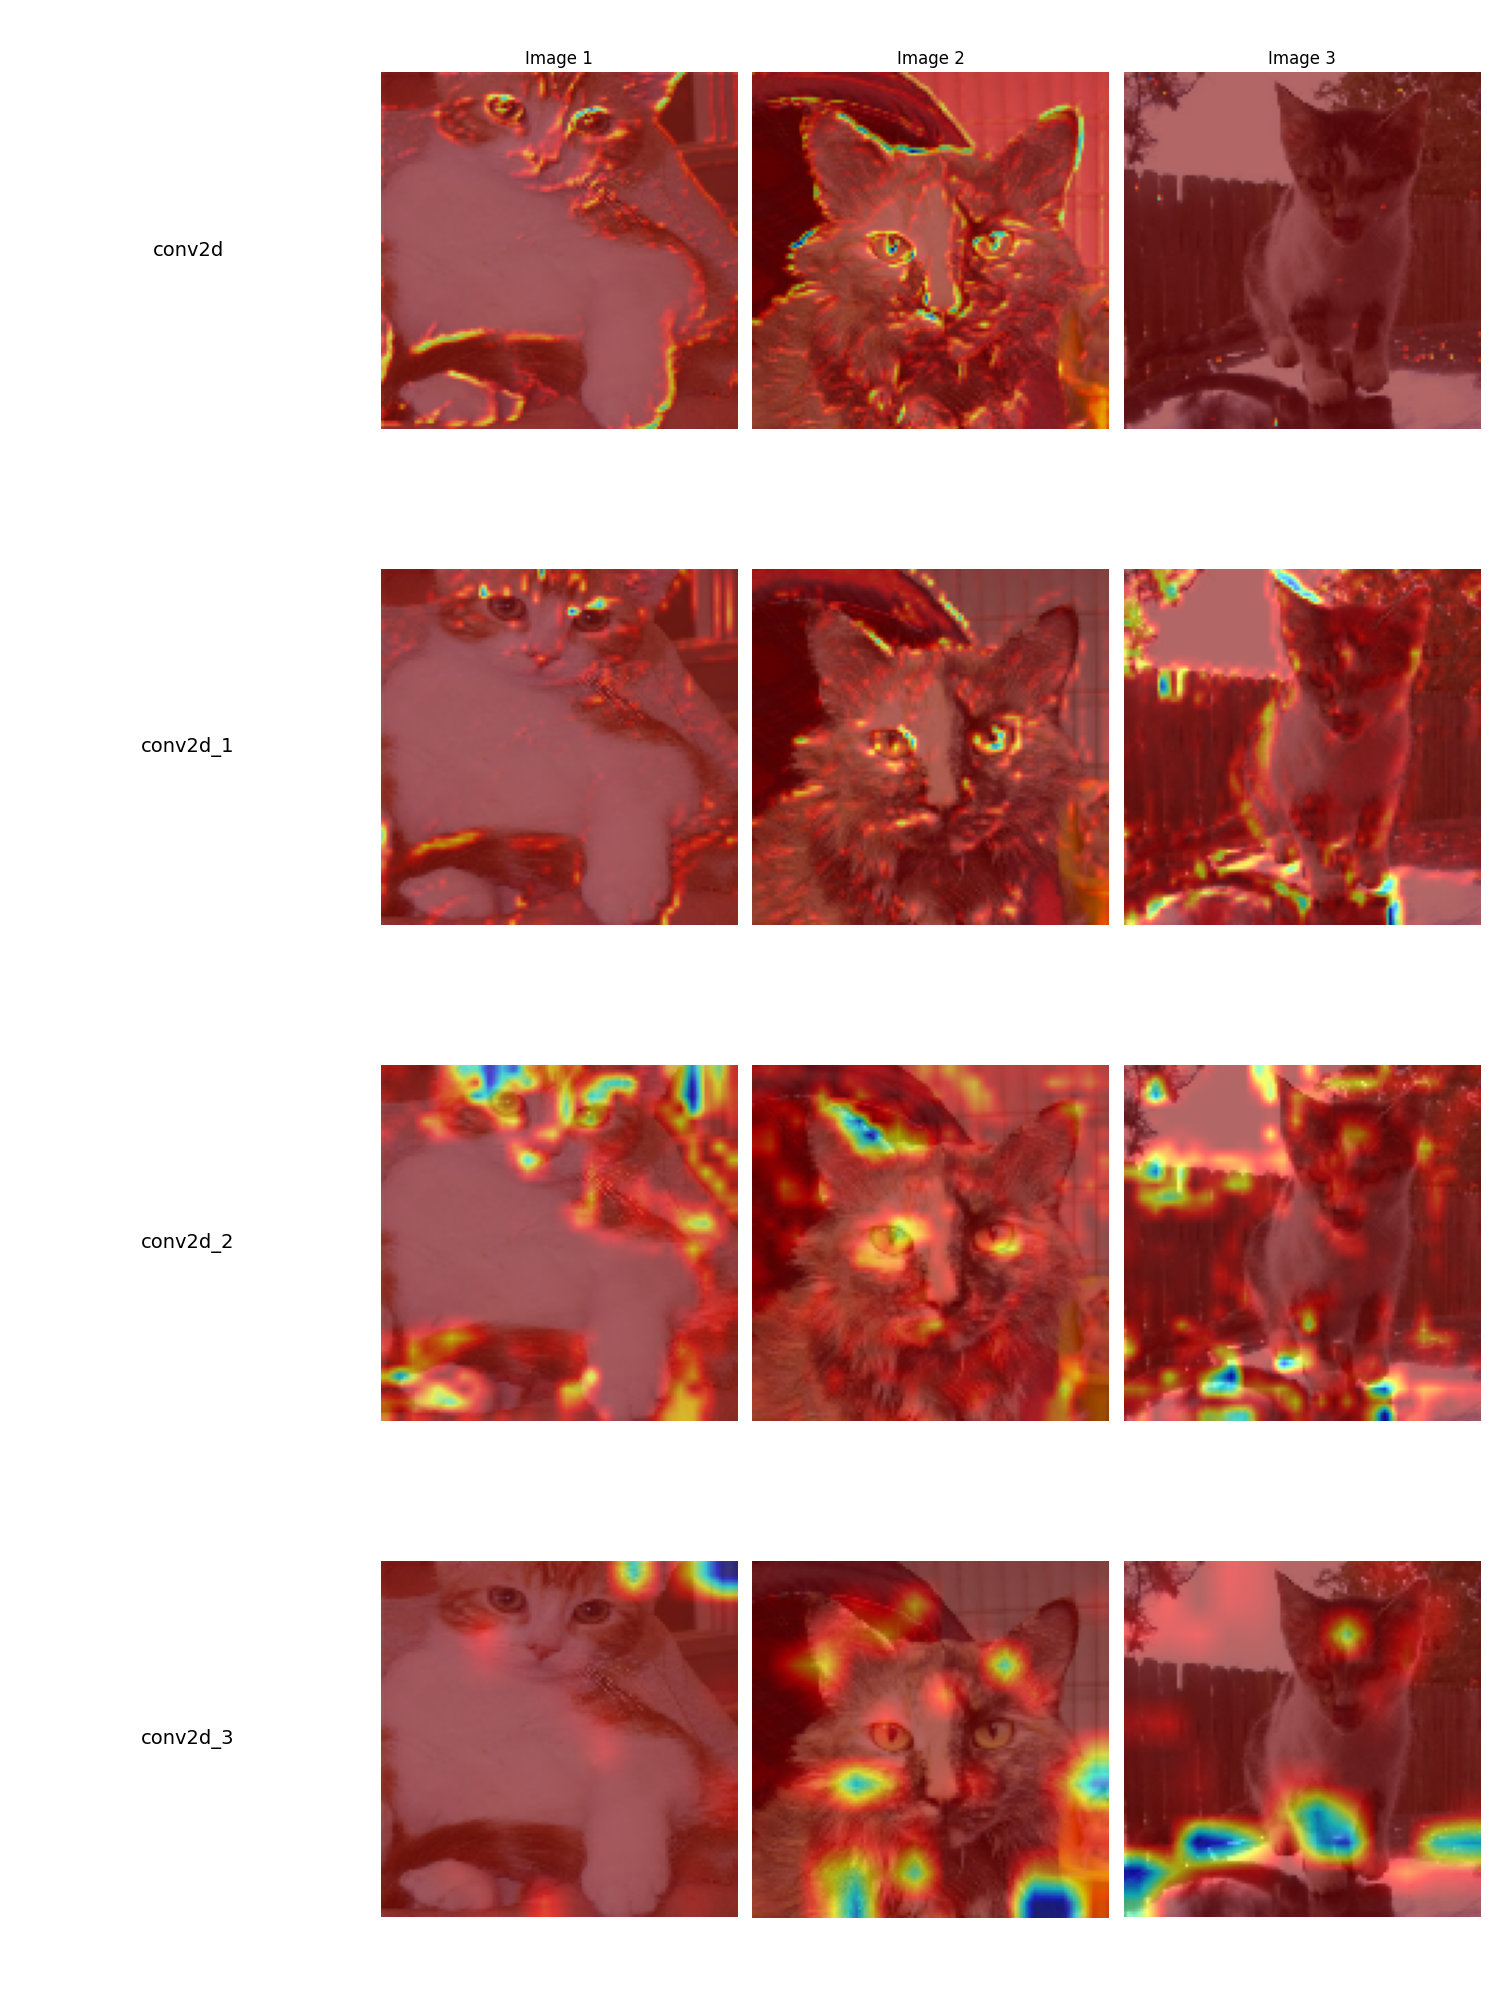

In [18]:
def plot_grad_cam_with_labels(model, image_paths, conv_layers):
    num_images = 3  # Number of images to display per layer
    selected_images = image_paths[:num_images]  # Select the first 3 images for visualization
    
    plt.figure(figsize=(15, len(conv_layers) * 5))  # Adjust figure size
    
    for layer_idx, layer_name in enumerate(conv_layers):
        # Add a label for the convolutional layer at the start of each row
        plt.subplot(len(conv_layers), num_images + 1, layer_idx * (num_images + 1) + 1)
        plt.text(0.5, 0.5, layer_name, fontsize=14, ha='center', va='center', wrap=True)
        plt.axis('off')  # No axis for the label

        for img_idx, img_path in enumerate(selected_images):
            img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

            # Get Grad-CAM heatmap
            heatmap_img = grad_cam(model, img_array, layer_name)

            # Plot the Grad-CAM heatmap
            plt.subplot(len(conv_layers), num_images + 1, layer_idx * (num_images + 1) + img_idx + 2)
            plt.imshow(heatmap_img)
            plt.axis('off')
            if layer_idx == 0:
                plt.title(f"Image {img_idx + 1}", fontsize=12)  # Label each column for the first row
    
    plt.tight_layout()
    plt.show()

# Extract all convolutional layer names from the model
conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Apply Grad-CAM visualization with labels
plot_grad_cam_with_labels(model, image_paths, conv_layers)


## 8- Testing Model

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 167ms/step

Confusion Matrix Results:
True Positives (TP): 1064
True Negatives (TN): 1046
False Positives (FP): 104
False Negatives (FN): 86

Metrics:
Precision: 0.91
Recall: 0.93
F1-Score: 0.92


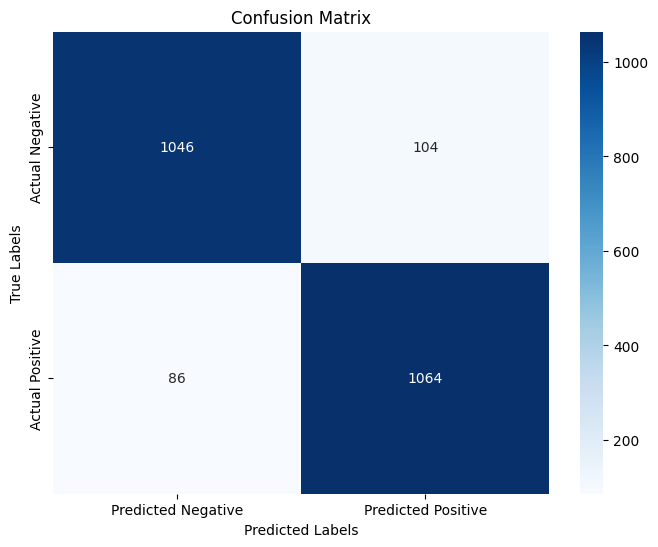

In [16]:
# Initialize confusion matrix variables
TP, TN, FP, FN = 0, 0, 0, 0

# Assuming `val_generator` is the validation data generator
# Loop through the validation data generator to get true labels and raw predictions
for i in range(len(val_generator)):
    # Get the batch of true labels and predictions
    x_batch, y_batch = val_generator[i]  # `x_batch` is input, `y_batch` is true labels
    Y_pred_batch = model.predict(x_batch)  # Predict on the batch
    
    # Convert predictions to binary labels using a threshold of 0.5
    y_pred_batch = (Y_pred_batch > 0.5).astype("int32").ravel()
    
    # Calculate TP, TN, FP, FN for the batch
    for true_label, predicted_label in zip(y_batch, y_pred_batch):
        if true_label == 1 and predicted_label == 1:
            TP += 1  # True Positive
        elif true_label == 0 and predicted_label == 0:
            TN += 1  # True Negative
        elif true_label == 0 and predicted_label == 1:
            FP += 1  # False Positive
        elif true_label == 1 and predicted_label == 0:
            FN += 1  # False Negative

# Print the results
print("\nConfusion Matrix Results:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


# Assuming TP, TN, FP, FN are already calculated
# Calculate Precision, Recall, and F1-score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print metrics
print("\nMetrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

# Build the confusion matrix
conf_matrix = np.array([[TN, FP],  # First row: [True Negative, False Positive]
                        [FN, TP]])  # Second row: [False Negative, True Positive]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### ERROR-ANALYSIS

72/72 [==============================] - 7s 95ms/step

Visualizing False Positives (Predicted: Dog, Actual: Cat):


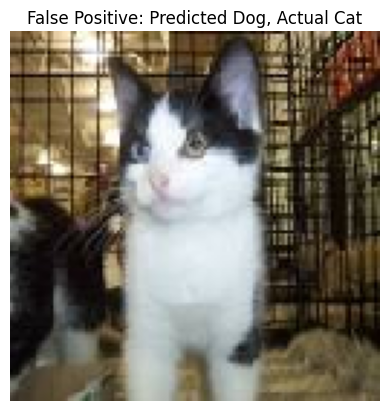

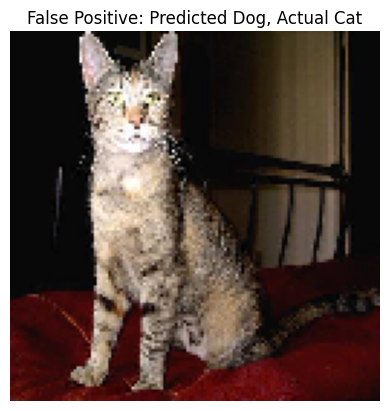

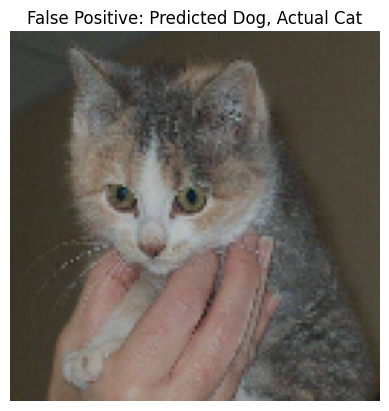

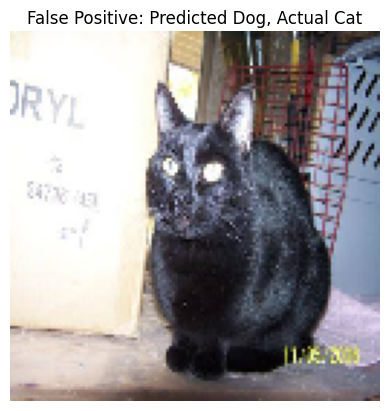

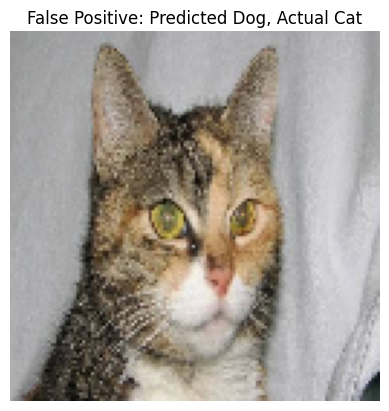


Visualizing False Negatives (Predicted: Cat, Actual: Dog):


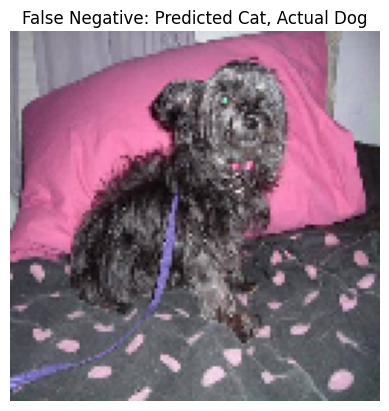

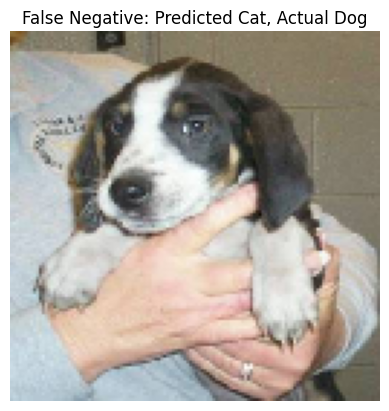

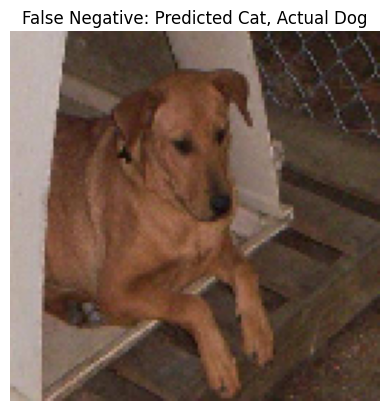

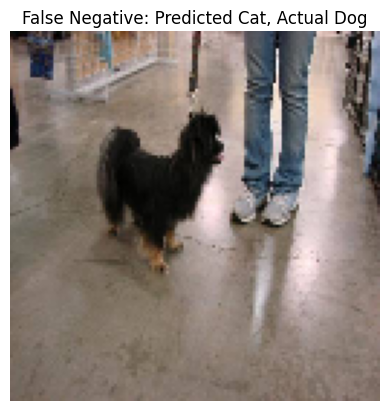

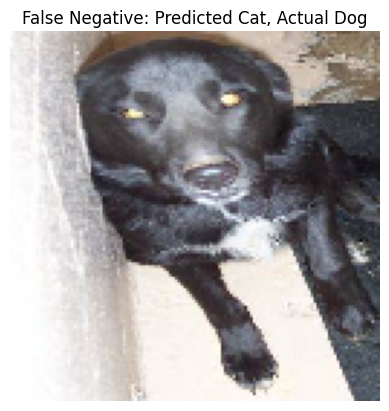

In [19]:
from tensorflow.keras.preprocessing import image
# Step 1: Identify Misclassified Examples
# Reset the generator to ensure consistent indexing
val_generator.reset()

# True labels and predictions
y_val_true = val_generator.classes  # Ground truth labels
y_val_pred_prob = model.predict(val_generator)  # Predicted probabilities
y_val_pred = (y_val_pred_prob > 0.5).astype("int32").ravel()  # Binary predictions

# Extract indices of misclassified examples
false_positives = [i for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred)) if true == 0 and pred == 1]
false_negatives = [i for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred)) if true == 1 and pred == 0]

# Step 2: Visualize False Positives
import matplotlib.pyplot as plt

print("\nVisualizing False Positives (Predicted: Dog, Actual: Cat):")
for idx in false_positives[:5]:  # Display the first 5 false positives
    img_path = val_generator.filepaths[idx]  # Retrieve the file path of the misclassified image
    img = image.load_img(img_path, target_size=(128, 128))  # Load the image
    plt.figure()
    plt.imshow(img)
    plt.title("False Positive: Predicted Dog, Actual Cat")
    plt.axis('off')
    plt.show()

# Step 3: Visualize False Negatives
print("\nVisualizing False Negatives (Predicted: Cat, Actual: Dog):")
for idx in false_negatives[:5]:  # Display the first 5 false negatives
    img_path = val_generator.filepaths[idx]  # Retrieve the file path of the misclassified image
    img = image.load_img(img_path, target_size=(128, 128))  # Load the image
    plt.figure()
    plt.imshow(img)
    plt.title("False Negative: Predicted Cat, Actual Dog")
    plt.axis('off')
    plt.show()


In [24]:
print(val_generator[1][0])
print(val_generator[1][1])

[[[[0.37647063 0.25490198 0.28627452]
   [0.3647059  0.22352943 0.2627451 ]
   [0.38823533 0.21568629 0.26666668]
   ...
   [0.49803925 0.49803925 0.49803925]
   [0.48235297 0.48235297 0.48235297]
   [0.48235297 0.48235297 0.48235297]]

  [[0.47450984 0.3529412  0.38431376]
   [0.4431373  0.3019608  0.34117648]
   [0.45882356 0.29411766 0.34117648]
   ...
   [0.49411768 0.49411768 0.49411768]
   [0.48235297 0.48235297 0.48235297]
   [0.48235297 0.48235297 0.48235297]]

  [[0.47450984 0.33333334 0.37254903]
   [0.454902   0.30588236 0.34901962]
   [0.45098042 0.28627452 0.33333334]
   ...
   [0.4901961  0.4901961  0.4901961 ]
   [0.48235297 0.48235297 0.48235297]
   [0.48235297 0.48235297 0.48235297]]

  ...

  [[0.5568628  0.53333336 0.48627454]
   [0.5647059  0.5411765  0.49411768]
   [0.5529412  0.5294118  0.48235297]
   ...
   [0.47058827 0.44705886 0.38431376]
   [0.47058827 0.44705886 0.38431376]
   [0.4666667  0.4431373  0.3803922 ]]

  [[0.56078434 0.5372549  0.4901961 ]
   [0.5

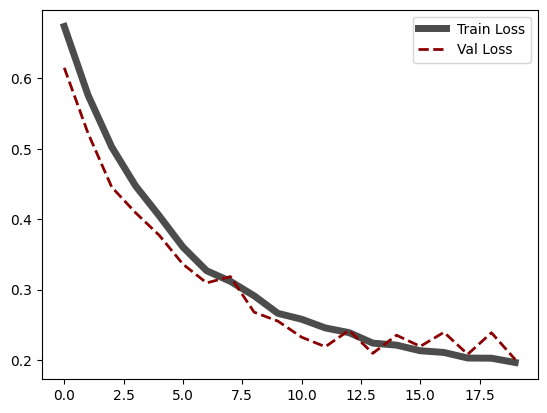

In [77]:
plt.plot(hist.history["loss"], label = "Train Loss", color = "black", alpha=0.7, linewidth=5)
plt.plot(hist.history["val_loss"], label = "Val Loss", color = "darkred", linewidth=2, linestyle='dashed')

plt.legend()
plt.show()

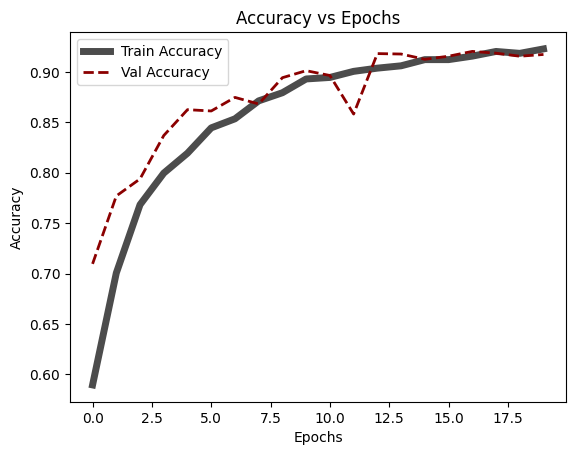

In [20]:
plt.plot(hist.history["accuracy"], label="Train Accuracy", color="black", alpha=0.7, linewidth=5)
plt.plot(hist.history["val_accuracy"], label="Val Accuracy", color="darkred", linewidth=2, linestyle='dashed')

plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


## 9- Hyperparameter tuning using keras tuner

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

def build_model(hp):
    model = Sequential()

    # Tune the number of convolutional layers (2 to 4)
    for i in range(hp.Int('conv_layers', 2, 4)):
        # Tune the number of filters (32, 64, or 128)
        filters = hp.Choice('filters', values=[32, 64, 128])
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Tune the number of dense layers (1 to 3)
    for i in range(hp.Int('dense_layers', 1, 3)):
        # Tune the number of units in the dense layer (32, 64, or 128)
        units = hp.Choice('units', values=[32, 64, 128])
        model.add(Dense(units, activation='relu'))

    # Binary classification output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_logs',
    project_name='cats_vs_dogs_tuning'
)

# Set up TensorBoard callback
tensorboard = TensorBoard(log_dir='logs')

# Start the search using data generators
tuner.search(train_generator, validation_data=val_generator, epochs=8, callbacks=[tensorboard])

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
print(f"Number of Conv Layers: {best_hp.get('conv_layers')}")
print(f"Filters: {best_hp.get('filters')}")
print(f"Number of Dense Layers: {best_hp.get('dense_layers')}")
print(f"Units in Dense Layers: {best_hp.get('units')}")




Trial 10 Complete [01h 29m 45s]
val_accuracy: 0.8508695363998413

Best val_accuracy So Far: 0.8508695363998413
Total elapsed time: 10h 02m 15s
Best hyperparameters:
Number of Conv Layers: 4
Filters: 128
Number of Dense Layers: 2
Units in Dense Layers: 64


## 10. Saving Model

In [29]:
model.save("static/models/catsdogs_classifier.h5")

# **Part 2: Pre-trained Keras Model**

In [78]:
# Load the MobileNet model without the top layers
mobile_new = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [79]:
# Freeze all layers except the last 23 layers
for layer in mobile_new.layers[:-23]:  # Only train the last 23 layers
    layer.trainable = False

In [80]:
# Add new layers on top of MobileNet
x = mobile_new.output
x = GlobalAveragePooling2D()(x)  # Reduce the 4D output to 2D
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

In [81]:
# Create the final model
model = Model(inputs=mobile_new.input, outputs=output)

In [82]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
# Train the model
model.fit(x=train_generator, validation_data=val_generator, epochs=10, verbose=2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
647/647 - 334s - loss: 0.1186 - accuracy: 0.9535 - val_loss: 0.0909 - val_accuracy: 0.9652 - 334s/epoch - 516ms/step
Epoch 2/10
647/647 - 360s - loss: 0.0690 - accuracy: 0.9729 - val_loss: 0.0621 - val_accuracy: 0.9761 - 360s/epoch - 557ms/step
Epoch 3/10
647/647 - 341s - loss: 0.0542 - accuracy: 0.9792 - val_loss: 0.0591 - val_accuracy: 0.9800 - 341s/epoch - 528ms/step
Epoch 4/10

In [84]:
prediction_new = model.predict(x=val_generator, verbose=0)
prediction_new[0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([1.], dtype=float32)

In [ ]:
#model.save("MyDrive/Dataset/Models/cats_dogs_classifier.h5")

In [ ]:
model.save("cats_dog_classifier.h5")

Saved model to disk
